# Detecting Credit Card Fraud
We have a dataset consisting of credit card transactions classified into two types of records: fraud and non-fraud. We try to understand the features present in the data, their importance in predicting our target class and finally build a model to classify frauds with a high precision.

In the steps below, first we prepare out dataset and perform exploratory data analysis to understand the features present. Then, we do the necessary feature encoding and engineering before moving on to build our model and evaluate it.

### Load the data

In [130]:
#import necessary packages
import nbconvert
import numpy as np # linear algebra
import pandas as pd # data processing with dataframes
import seaborn as sns #plotting
import matplotlib.pyplot as plt #plotting

#read and load the csv files into dataframes
card_base=pd.read_csv('CardBase.csv');
cust_base=pd.read_csv('CustomerBase.csv');
fraud_base=pd.read_csv('FraudBase.csv');
transaction_base=pd.read_csv('TransactionBase.csv');

#Join/merge the four datasets to get a consolidated overview
df1=pd.merge(cust_base, card_base, how="left", on=["Cust_ID"])
df2=pd.merge(df1,transaction_base,how="left", left_on='Card_Number', right_on='Credit_Card_ID' )
transaction_all= pd.merge(df2,fraud_base, how="left", on="Transaction_ID" )

#Drop the duplicate column appearing twice
transaction_all.drop('Credit_Card_ID', axis=1)

#Get the number of rows and columns present in the consolidated data
transaction_all.shape

(15192, 13)

###  Exploratory Data Analysis

Here, we get a glimpse of our dataset.

In [131]:
#View the top 10 rows
transaction_all.head(10)

,Cust_ID,Age,Customer_Segment,Customer_Vintage_Group,Card_Number,Card_Family,Credit_Limit,Transaction_ID,Transaction_Date,Credit_Card_ID,Transaction_Value,Transaction_Segment,Fraud_Flag
0,CC25034,35,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CC59625,22,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CC69314,33,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC67036,46,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CC25597,44,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CC57469,22,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CC15926,50,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CC31951,46,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CC32388,26,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CC48802,44,Diamond,VG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that there are null values present in multiple columns. We try to understand the datatypes of the different columns present and check for columns containing null values

In [132]:
#get info about all columns: dataypes and number of null values contained
transaction_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15192 entries, 0 to 15191
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cust_ID                 15192 non-null  object 
 1   Age                     15192 non-null  int64  
 2   Customer_Segment        15192 non-null  object 
 3   Customer_Vintage_Group  15192 non-null  object 
 4   Card_Number             10000 non-null  object 
 5   Card_Family             10000 non-null  object 
 6   Credit_Limit            10000 non-null  float64
 7   Transaction_ID          10000 non-null  object 
 8   Transaction_Date        10000 non-null  object 
 9   Credit_Card_ID          10000 non-null  object 
 10  Transaction_Value       10000 non-null  float64
 11  Transaction_Segment     10000 non-null  object 
 12  Fraud_Flag              109 non-null    float64
dtypes: float64(3), int64(1), object(9)
memory usage: 1.6+ MB


We see from the above output that many columns contain equal number of null values. We will drop null values from one particular column to check if other columns contain missing values in the same rows. 

We also drop the duplicates present.

In [133]:
transaction_all.drop_duplicates(inplace=True)
transaction_all.dropna(subset=['Card_Number'],inplace=True)
transaction_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 12 to 15179
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cust_ID                 10000 non-null  object 
 1   Age                     10000 non-null  int64  
 2   Customer_Segment        10000 non-null  object 
 3   Customer_Vintage_Group  10000 non-null  object 
 4   Card_Number             10000 non-null  object 
 5   Card_Family             10000 non-null  object 
 6   Credit_Limit            10000 non-null  float64
 7   Transaction_ID          10000 non-null  object 
 8   Transaction_Date        10000 non-null  object 
 9   Credit_Card_ID          10000 non-null  object 
 10  Transaction_Value       10000 non-null  float64
 11  Transaction_Segment     10000 non-null  object 
 12  Fraud_Flag              109 non-null    float64
dtypes: float64(3), int64(1), object(9)
memory usage: 1.1+ MB


We see that now there are no null values present in our dataset. 

Our target column- Fraud_Flag is an object type column. We convert this an integer-type column for building our model, and fill the Fraud_Flag column with 0 for the non-fraud records.

Also, converting the Transaction_Date colum to datetime so that extraction of necessary information is possible.

In [112]:
#fill 0 as the value is the Fraud_Fla column for the valid transactions
transaction_all['Fraud_Flag'].fillna(0, inplace=True)
transaction_all['Fraud_Flag']=transaction_all['Fraud_Flag'].astype(int)
transaction_all['Transaction_Date']=pd.to_datetime(transaction_all['Transaction_Date'])

We plot the correlation matrix for checking any correlation between the numerical features

                        Age  Credit_Limit  Transaction_Value  Fraud_Flag
Age                1.000000     -0.012878          -0.001739   -0.006525
Credit_Limit      -0.012878      1.000000          -0.006661   -0.005704
Transaction_Value -0.001739     -0.006661           1.000000    0.014976
Fraud_Flag        -0.006525     -0.005704           0.014976    1.000000


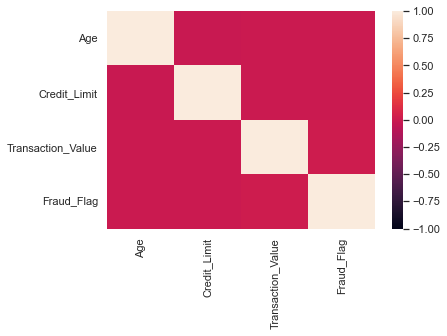

In [113]:
#Checking the correlation matrix for finding correlation between the numeric variables
corr_matrix = transaction_all.corr()
print(corr_matrix)
fig = plt.figure(figsize = (6, 4))
sns.heatmap(corr_matrix, vmin=-1, vmax=1)
plt.show()

Next, we try to understand how imbalanced our dataset is with the help of a countplot

<AxesSubplot:xlabel='Fraud_Flag', ylabel='count'>

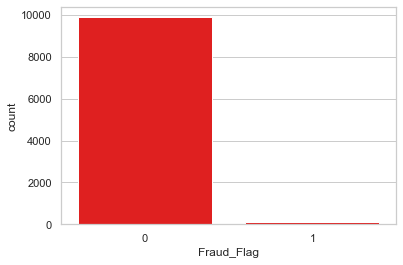

In [114]:
sns.countplot(x=transaction_all['Fraud_Flag'],color='red')

#plt.show()

Thus, we see that we are dealing with a very heavily imbalanced dataset here. We will be using sampling methods to effectively deal with this, prior to building our classification model.

### Exploring high-level summary of transactions and frauds

We have a number of categorical variables present in our dataset. We will visualize the total number of frauds against these categories for making a high-level comparitive study

<Figure size 432x288 with 0 Axes>

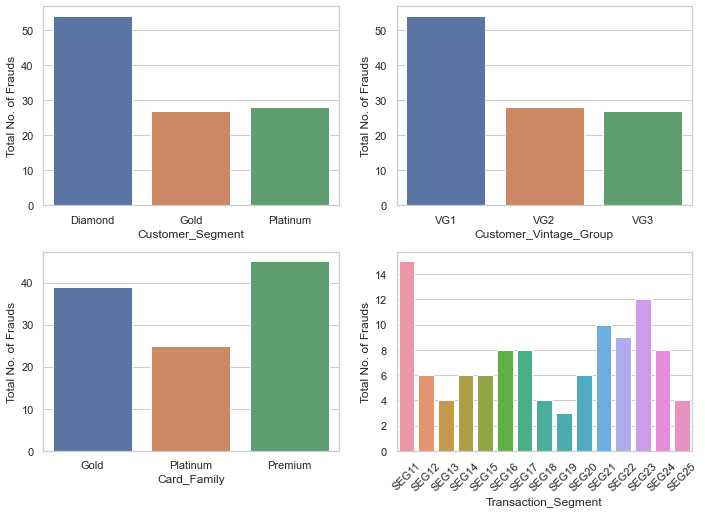

In [115]:
#Using seaborn to draw 4 barplots for 4 different categorical variab;es
sns.set_theme(style='whitegrid')

fig = plt.figure()

cust_seg=transaction_all.groupby(['Customer_Segment'])[['Fraud_Flag']].sum().reset_index()
cust_grp=transaction_all.groupby(['Customer_Vintage_Group'])[['Fraud_Flag']].sum().reset_index()
card_fam=transaction_all.groupby(['Card_Family'])[['Fraud_Flag']].sum().reset_index()
trans_seg=transaction_all.groupby(['Transaction_Segment'])[['Fraud_Flag']].sum().reset_index()

fig, axes = plt.subplots(2,2,figsize=(10, 7))

ax1=sns.barplot(data = cust_seg, x='Customer_Segment', y='Fraud_Flag', ax=axes[0,0])
ax1.set( ylabel='Total No. of Frauds')

ax2=sns.barplot(data = cust_grp, x='Customer_Vintage_Group', y='Fraud_Flag', ax=axes[0,1])
ax2.set( ylabel='Total No. of Frauds')

ax3=sns.barplot(data = card_fam, x='Card_Family', y='Fraud_Flag', ax=axes[1,0])
ax3.set( ylabel='Total No. of Frauds')

ax4=sns.barplot(data = trans_seg, x='Transaction_Segment', y='Fraud_Flag', ax=axes[1,1])
ax4.set( ylabel='Total No. of Frauds')

fig.tight_layout()

plt.xticks(rotation=45)
plt.show()

We see that Diamond Customer Segment and VG1 Customer Vintage Group account for more than 50% of the total frauds. However, the distribution of the first two plots appear very similar. We will explore if Customer Segment and Customer Vintage Group are directly co-related further below.

For Card Family- Premium, the total number of frauds is significantly higher than the other two categories. 

In [116]:
transaction_all[['Customer_Segment','Customer_Vintage_Group']].value_counts()

Customer_Segment  Customer_Vintage_Group
Diamond           VG1                       4460
Gold              VG3                       3252
Platinum          VG2                       2288
dtype: int64

We see that the two features Customer_Segment and Customer_Vintage_Group have a one-to-one direct relation. That is, for example, every Diamond Segment customer only belongs to the VG1 Customer Vintage Group and no other Customer Vintage Group. This holds true for the GOld and Platinum Segment customers as well.

Plotting the distribution of frauds by month:

<AxesSubplot:xlabel='month', ylabel='Fraud_Flag'>

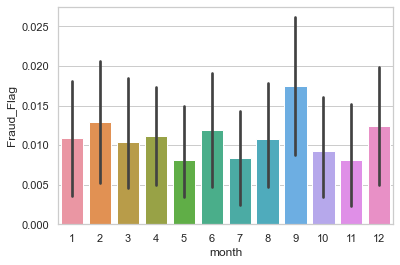

In [117]:
#transaction_all[['Transaction_Date']].value_counts()
transaction_all['year'] = pd.DatetimeIndex(transaction_all['Transaction_Date']).year
transaction_all['year']=transaction_all['year'].astype(int)

transaction_all['month'] = pd.DatetimeIndex(transaction_all['Transaction_Date']).month
transaction_all['month']=transaction_all['month'].astype(int)

transaction_all[['year','month']].value_counts()
df=transaction_all.groupby(['year','month'])[['Fraud_Flag']].sum().reset_index()

df.head(20)

sns.barplot(data=transaction_all, x='month', y='Fraud_Flag')

Visualizing the relationship between the different card families and their credit limit below:

<AxesSubplot:xlabel='Card_Family', ylabel='Credit_Limit'>

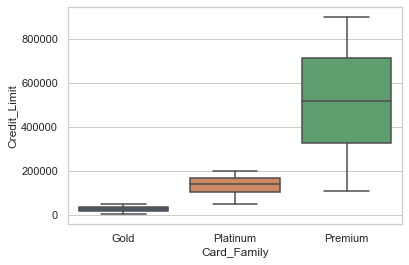

In [118]:
sns.boxplot(data=transaction_all, x='Card_Family', y='Credit_Limit')

Next, we try to understand how the numerical features relate to the cases of fraud using the plots below:

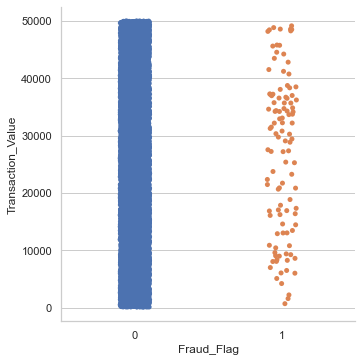

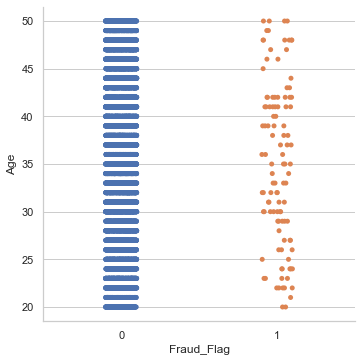

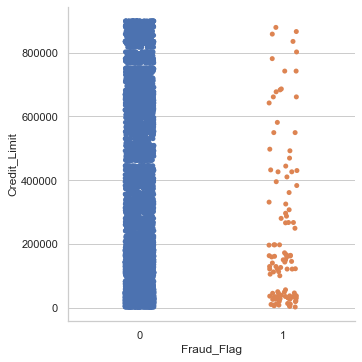

In [119]:
sns.catplot(data=transaction_all, x='Fraud_Flag', y='Transaction_Value')
sns.catplot(data=transaction_all, x='Fraud_Flag', y='Age')
sns.catplot(data=transaction_all, x='Fraud_Flag', y='Credit_Limit')

We can clearly see that, we have more cases of fraud in cards with lower credit limits.

## Encoding important categorical features:
Using one-hot dummy Encoding to encode categorical features like : Customer_Segment, Card_Family, Transaction_Segment.

In [120]:
transaction_all_1=pd.get_dummies(transaction_all, columns=['Customer_Segment'],  drop_first=True,prefix='Cust_').copy()
transaction_all_2=pd.get_dummies(transaction_all_1, columns=['Card_Family'], drop_first=True, prefix='Card_').copy()
#transaction_all_3=pd.get_dummies(transaction_all_2, columns=['Customer_Vintage_Group'], drop_first=True, prefix='CustVintGR_').copy()
transactions_onehot=pd.get_dummies(transaction_all_2, columns=['Transaction_Segment'], drop_first=True, prefix='Trans').copy()

## Feature Scaling
We see that the numerical features like Age, Credit_Limit and Transaction_Value have varying degrees of magnitude and range. So, in order to standardize them, we use feature scaling with Standard scaler.

In [121]:
from sklearn.preprocessing import StandardScaler

#using standard scaler
transactions_onehot['normAge'] = StandardScaler().fit_transform(transactions_onehot[['Age']])
transactions_onehot['normCredit_Limit'] = StandardScaler().fit_transform(transactions_onehot[['Credit_Limit']])
transactions_onehot['normTransaction_Value'] = StandardScaler().fit_transform(transactions_onehot[['Transaction_Value']])

#dropping the features we will not be using for our model input
drop_features=['Age','Cust_ID','Card_Number','Credit_Limit','Transaction_Value','Customer_Vintage_Group','Transaction_ID','Transaction_Date','Credit_Card_ID','year','month',"Fraud_Flag"]

#preparing the feature and target variables for our model-before sampling
X=transactions_onehot.drop(drop_features, axis=1)
Y = transactions_onehot["Fraud_Flag"]
X.columns
X.head()

,Cust__Gold,Cust__Platinum,Card__Platinum,Card__Premium,Trans_SEG12,Trans_SEG13,Trans_SEG14,Trans_SEG15,Trans_SEG16,Trans_SEG17,...,Trans_SEG19,Trans_SEG20,Trans_SEG21,Trans_SEG22,Trans_SEG23,Trans_SEG24,Trans_SEG25,normAge,normCredit_Limit,normTransaction_Value
12,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,-0.636981,-0.832997,-0.351956
13,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,-0.636981,-0.832997,-0.139575
14,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,-0.636981,-0.832997,-0.059688
15,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,-0.636981,-0.832997,1.526353
16,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,-0.636981,-0.832997,1.524474


Next we try to find the quantitative imbalance present in the data.

In [122]:
#output the imbalance in the data
fraud = transactions_onehot[transactions_onehot['Fraud_Flag'] == 1] 
valid = transactions_onehot[transactions_onehot['Fraud_Flag'] == 0] 
outlierFraction = len(fraud)/float(len(valid)) 
print(outlierFraction) 
print('Fraud Cases: {}'.format(len(transactions_onehot[transactions_onehot['Fraud_Flag'] == 1]))) 
print('Valid Transactions: {}'.format(len(transactions_onehot[transactions_onehot['Fraud_Flag'] == 0]))) 

0.011020119300374078
Fraud Cases: 109
Valid Transactions: 9891


We see that just a little over 1% of the cases are classified as fraud. This clearly shows that the datatset is heavily imbalanced.

### Sampling - Oversampling

We use random oversampling to scale up the minority class and train our model to even out the imbalance in our dataset.

In [123]:
from sklearn.utils import resample

fraud_upsampled = resample(fraud,
                                replace = True,
                                n_samples = len(valid), # match minority n
                                random_state = 27,
                                ) 

oversampled = pd.concat([valid, fraud_upsampled])

#creating our feature and target arrays from the sampled data
X_over =oversampled.drop(drop_features, axis=1)
Y_over = oversampled["Fraud_Flag"]

#printing the counts for fraud and non-fraud cases in our resampled data
oversampled.Fraud_Flag.value_counts()

0    9891
1    9891
Name: Fraud_Flag, dtype: int64

### Building our model:

We build two classifiers: Logistic Regression and Random Forest Classifier and evaluate them to select the one with the best precision and recall. Since our dataset is imbalanced, accuracy is not a correct metric for model evaluation.

In [124]:
#import necessary packages for building a logistic regression mode and Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#import necessary packages for evaluation metrics
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

print(X.shape)
print(Y.shape)
# getting just the values for the sake of processing 
xData = X.values
yData = Y.values

xTrain, xTest, yTrain, yTest = train_test_split(
        xData, yData, test_size = 0.2, random_state = 42)

(10000, 21)
(10000,)


We train the model with the resampled data and then evaluate it with data from our original dataset.

In [125]:
#splitting out dataset into testing and training sets
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(
        X_over, Y_over, test_size = 0.2, random_state = 42)

#building the Random forest classifier from our sampled training data
rfc2 = RandomForestClassifier()
# fitting the classifier to the oversampled training data
rfc2.fit(xTrain2, yTrain2)
yPred2 = rfc2.predict(xTest)
print(yPred2)

logreg = LogisticRegression()
logreg.fit(xTrain2, yTrain2)

# Predict the labels of the test set
y_pred_log2 = logreg.predict(xTest)

[0 0 0 ... 0 0 0]


## Evaluating our model:

We evaluate our classification model based on precision, Recall and F1-score. Accuracy is not a correct metric here, since our dataset is highly skewed in favour of one particular class.

Model: Random Forest classifier
Accuracy: 0.9995
Precision: 0.9523809523809523
Recall: 1.0
F1 Score 0.975609756097561


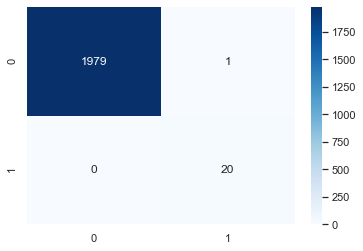



Model: Logistic Regression
Accuracy: 0.548
Precision for logReg: 0.012141280353200883
Recall: 0.55
F1 Score 0.023758099352051837
[[1085  895]
 [   9   11]]


In [126]:
print("Model: Random Forest classifier")

#Computing the accuracy, precision, recall and F1 score for the RF classifier
acc = accuracy_score(yTest, yPred2)
print("Accuracy: {}".format(acc))
prec = precision_score(yTest, yPred2)
print("Precision: {}".format(prec))
rec = recall_score(yTest, yPred2)
print("Recall: {}".format(rec))
f1 = f1_score(yTest, yPred2)
print("F1 Score {}".format(f1))
cf_matrix=confusion_matrix(yTest, yPred2)
labels = ['True Negative','False Positive','False Negative','True Positive']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
plt.show()

print("\n\nModel: Logistic Regression")
#Computing the accuracy, precision, recall and F1 score for the Ogistic Regression model
acc = accuracy_score(yTest, y_pred_log2)
print("Accuracy: {}".format(acc))
prec_log = precision_score(yTest, y_pred_log2)
print("Precision for logReg: {}".format(prec_log))
rec_log = recall_score(yTest, y_pred_log2)
print("Recall: {}".format(rec_log))
f1 = f1_score(yTest, y_pred_log2)
print("F1 Score {}".format(f1))
print(confusion_matrix(yTest, y_pred_log2))

### Understanding feature importances:

We try to understand the relative importance of the different features in our RF model with help of the barplot below:

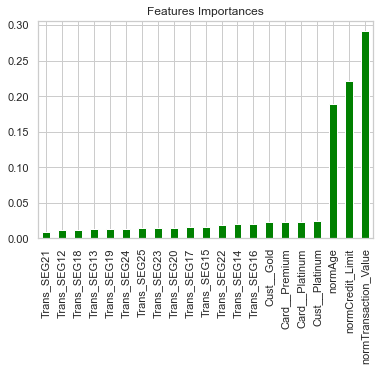

In [127]:
importances = pd.Series(data=rfc2.feature_importances_,
                        index= xTrain2.columns)
importances_sorted = importances.sort_values()
#plotting the feature importances
importances_sorted.plot(kind='bar', color='green')
plt.title('Features Importances')
plt.show()

## Hyperparameter tuning for Logistic Regression:

In [128]:
from sklearn.model_selection import GridSearchCV
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiating a logreg classifier
logreg = LogisticRegression()

# Instantiating the GridSearchCV
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fitting to the training data
logreg_cv.fit(xTrain2, yTrain2)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

y_pred_log2 = logreg_cv.predict(xTest)
print("\nModel: Logistic Regression")

#Computing the evaluation scores
acc = accuracy_score(yTest, y_pred_log2)
print("Accuracy: {}".format(acc))
prec_log = precision_score(yTest, y_pred_log2)
print("Precision for logReg: {}".format(prec_log))
rec_log = recall_score(yTest, y_pred_log2)
print("Recall: {}".format(rec_log))
f1 = f1_score(yTest, y_pred_log2)
print("F1 Score {}".format(f1))
print(confusion_matrix(yTest, y_pred_log2))

Tuned Logistic Regression Parameters: {'C': 268.2695795279727}
Best score is 0.5993680884676145

Model: Logistic Regression
Accuracy: 0.5485
Precision for logReg: 0.012154696132596685
Recall: 0.55
F1 Score 0.023783783783783784
[[1086  894]
 [   9   11]]


Tuning hyperparamter C for Logistic Regression only marginally increases the performance of the model, the RF Classifier still performs much better.

So, for predicting credit card frauds, it is better to use a Random Forest Classifier.